# Korišćenje neuronskih mreža u regresionim zadacima

Zadatak:
 - dizajnirati i istrenirati neuronsku mrežu za predikciju cena nekretnina
 - skup podataka: Boston Housing dataset
 - dizajn rešenja: neuronska mreža sa propagacijom unapred

In [1]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

SEED = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# za determinističko izvršavanje sveske:
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


## Priprema skupa podataka

*Boston housing* je skup podataka namenjen razviju modele za predviđanje cena nekretnina u Bostonu. Sadrži 13 različitih atributa koji obuhvataju različite aspekte stambenih objekata i njihovih okolina. Atributi uključuju, između ostalog, površinu nekretnine, broj soba, stopu kriminala u oblasti, pristup putevima i poreze. Više o ovom skupu podataka možete pročitati [ovde](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html).

In [2]:
data_url = "https://lib.stat.cmu.edu/datasets/boston"
column_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS",
    "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"
]

raw_data = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None).values
raw_data = np.hstack([raw_data[::2], raw_data[1::2]])[:, :14]
raw_data = pd.DataFrame(raw_data, columns=column_names)
raw_data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [3]:
from sklearn import model_selection

X = raw_data.drop(columns=["MEDV"])
y = raw_data["MEDV"]
X_train_valid, X_test, y_train_valid, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=7)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train_valid, y_train_valid, test_size=0.1, random_state=7)

In [4]:
print("X_train", X_train.shape, type(X_train))
print("y_train", y_train.shape, type(y_train))
print("X_valid", X_valid.shape, type(X_valid))
print("y_valid", y_valid.shape, type(y_valid))
print("X_test", X_test.shape, type(X_test))
print("y_test", y_test.shape, type(y_test))

X_train (305, 13) <class 'pandas.core.frame.DataFrame'>
y_train (305,) <class 'pandas.core.series.Series'>
X_valid (34, 13) <class 'pandas.core.frame.DataFrame'>
y_valid (34,) <class 'pandas.core.series.Series'>
X_test (167, 13) <class 'pandas.core.frame.DataFrame'>
y_test (167,) <class 'pandas.core.series.Series'>


Nakon učitavanja, podatke ćemo i standardizovati.

In [5]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [6]:
print("X_train", X_train.shape, type(X_train), sep='\t')
print("y_train", y_train.shape, type(y_train), sep='\t')
print("X_valid", X_valid.shape, type(X_valid), sep='\t')
print("y_valid", y_valid.shape, type(y_valid), sep='\t')
print("X_test", X_test.shape, type(X_test), sep='\t')
print("y_test", y_test.shape, type(y_test), sep='\t')

X_train	(305, 13)	<class 'numpy.ndarray'>
y_train	(305,)	<class 'pandas.core.series.Series'>
X_valid	(34, 13)	<class 'numpy.ndarray'>
y_valid	(34,)	<class 'pandas.core.series.Series'>
X_test	(167, 13)	<class 'numpy.ndarray'>
y_test	(167,)	<class 'pandas.core.series.Series'>


Kako torch biblioteka ne radi sa pandas objektima, prebacicemo ciljnu promenjivu u numpy

### Kreiranje mreže

Mreža koju ćemo napraviti će biti mreža sa propagacijom unapred. Ulaz u mrežu biće vektor dimenzije 13. Mreža će imati jedan skriveni sloj sa 100 neurona. Izlazni sloj imaće jedan neuron jer mreža treba da predvidi cenu nekretnine. Za aktivacionu funkciju skrivenog sloja odabraćemo `ReLu`, dok ćemo za drugi, izlazni sloj, izostaviti aktivaionu funkciju što je standardni izbor u slučajevima regresionih zadataka. Aktivaciona funkcija bi ograničavala opseg koje mreža može da nauči što je u suprotnosti sa očekivanjima regresionih zadataka.

In [7]:
number_of_features = X_train.shape[1]
output_size = 1

In [8]:
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(RegressionModel, self).__init__()
        layers = [
            nn.Linear(input_size, 100),
            nn.ReLU(),
            nn.Linear(100, output_size),
        ]
        self.model = nn.Sequential(*layers)

        # na ovaj način se može promeniti inicijalizacija težina
        self.apply(self.init_weights)

    def forward(self, x):
        return self.model(x)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

In [9]:
model = RegressionModel(number_of_features, output_size)
print(model)
print("Broj parametara modela: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

RegressionModel(
  (model): Sequential(
    (0): Linear(in_features=13, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)
Broj parametara modela:  1501


## Treniranje mreže

U regresionim zadacima za funkciju greške najčešće koristimo srednjekvadratnu grešku (engl. mean squared error). Pored nje od interesa nam mogu biti i druge metrike. Jedna od čestih metrika koje pratimo je srednja apsolutna greška (eng. mean absolute error).

Mrežu ćemo trenirati u 100 epoha sa paketićima veličine 32 instance. Ovoga puta ćemo postaviti i `verbose` parametar funkcije na vrednost 1 kako bismo mogli da pratimo ispise u toku izvršavanja funkcije.

In [10]:
N_EPOCHS = 200
BATCH_SIZE = 32

In [11]:
from torch.utils.data import TensorDataset, DataLoader

X_train, y_train = torch.FloatTensor(X_train), torch.FloatTensor(y_train.to_numpy())
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

X_valid, y_valid = torch.FloatTensor(X_valid), torch.FloatTensor(y_valid.to_numpy())
valid_dataset = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt

model.to(DEVICE)

metrics = {
    'train_mse': [],
    'train_mae': [],
    'train_step': [],
    'val_mse': [],
    'val_mae': [],
    'val_step': [],
}


learning_rate = 0.01        # stopa ucenja
NUM_EPOCHS = 100   # broj epoha

# definisanje algoritma optimizacije
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# nekada se neki slojevi modela ponasaju drugačije tokom treniranja i testiranja
# zato prebacujemo model u režim treniranja
training_step = 0
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        # Računanje predviđanja modela
        y_pred = model(x_batch)

        # Izračunavanje greške
        loss = nn.functional.mse_loss(y_pred, y_batch.view(-1, 1))
        
        # Resetovanje gradijenata
        optimizer.zero_grad()

        # Računanje gradijenata propagacijom unazad
        loss.backward()

        # Ažuriranje težina
        optimizer.step()

        # čuvanje metrika
        metrics['train_mse'].append(loss.item())
        metrics['train_mae'].append((y_pred - y_batch.view(-1, 1)).abs().mean().item())
        metrics['train_step'].append(training_step)
        training_step += 1
    
    # testiranje modela
    model.eval()
    with torch.no_grad():  # isključivanje izračunavanja gradijenata
        validation_mse = 0
        validation_mae = 0
        total_samples = 0
        for x_batch, y_batch in valid_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            # Računanje predviđanja modela
            y_pred = model(x_batch)

            # Izračunavanje greške
            mse = nn.functional.mse_loss(y_pred, y_batch.view(-1, 1), reduction='sum')
            mae = (y_pred - y_batch.view(-1, 1)).abs().sum()
            validation_mse += mse.item()
            validation_mae += mae.item()
            total_samples += y_batch.size(0)
        # Računanje prosečne greške
        validation_mse /= total_samples
        validation_mae /= total_samples
        # čuvanje metrika
        metrics['val_mse'].append(validation_mse)
        metrics['val_mae'].append(validation_mae)
        metrics['val_step'].append(training_step)


100%|██████████| 100/100 [00:00<00:00, 127.34it/s]


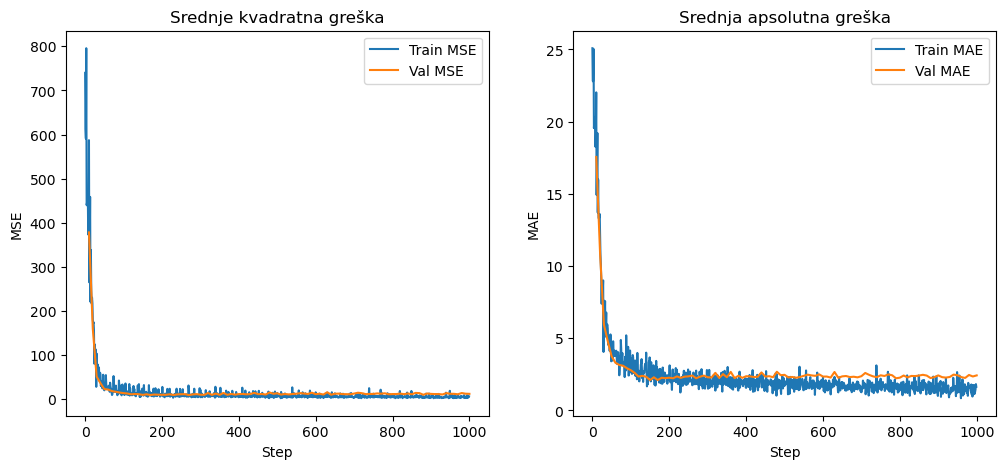

In [13]:
# vizualizacija metrika
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['train_step'], metrics['train_mse'], label='Train MSE')
plt.plot(metrics['val_step'], metrics['val_mse'], label='Val MSE')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.title('Srednje kvadratna greška')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics['train_step'], metrics['train_mae'], label='Train MAE')
plt.plot(metrics['val_step'], metrics['val_mae'], label='Val MAE')
plt.xlabel('Step')
plt.ylabel('MAE')
plt.title('Srednja apsolutna greška')
plt.legend()

plt.show()

## Evaluacija mreže

In [14]:
X_test, y_test = torch.FloatTensor(X_test), torch.FloatTensor(y_test.to_numpy())
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [15]:
model.eval()
test_mse, test_mae, test_samples = 0, 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        batch_size = inputs.size(0)


        predictions = model(inputs).squeeze()
        mse = (predictions - labels).pow(2).mean()
        mae = (predictions - labels).abs().mean()

        test_mse += mse.item() * batch_size
        test_mae += mae.item() * batch_size
        test_samples += batch_size
test_mse /= test_samples
test_mae /= test_samples
print(f"{test_mae=}")
print(f"{test_mse=}")

test_mae=2.249616179637566
test_mse=12.478581385698147


Ukoliko su nam potrebne i druge metrike evaluacije, možemo iskoristiti funkcije biblioteke `scikit-learn`.

In [16]:
from sklearn import metrics

In [17]:
model.eval()
with torch.no_grad():
    y_predicted = model(X_test.to(DEVICE)).cpu().numpy()

In [18]:
metrics.r2_score(y_test, y_predicted)

0.8355603814125061

Analizom grafika funkcije greške možemo zaključiti da je došlo do malog preprilagođavanja modela. Greška na trening skupu je nastavila da opada, dok je greška na validacionom skupu stagnirala.

Ovo nije poželjno, tako da možemo iskoristiti tehniku ranog zaustavljanja treninga (eng. early stopping). Ukoliko najbolja greška na validacionom skupu prestane da opada možemo zaustaviti trening.

Modifikovaćemo kod za trening kako bi uveli ovu heuristiku:

In [19]:
model2 = RegressionModel(number_of_features, output_size)
model2.to(DEVICE)
optimizer = Adam(params=model2.parameters(), lr=0.01)
metrics2 = defaultdict(lambda: {'train': [], 'valid': []})

best_val_loss = float('inf')
early_stopping_patience = 10  # broj epoha koji čekamo na poboljšanje
eps = 1e-5                    # minimalno poboljšanje koje očekujemo
steps_since_improvment = 0

metrics = {
    'train_mse': [],
    'train_mae': [],
    'train_step': [],
    'val_mse': [],
    'val_mae': [],
    'val_step': [],
}

training_step = 0
for epoch in tqdm(range(NUM_EPOCHS)):
    model2.train()
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        y_pred = model2(x_batch)

        loss = nn.functional.mse_loss(y_pred, y_batch.view(-1, 1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metrics['train_mse'].append(loss.item())
        metrics['train_mae'].append((y_pred - y_batch.view(-1, 1)).abs().mean().item())
        metrics['train_step'].append(training_step)
        training_step += 1
    
    model2.eval()
    with torch.no_grad():
        validation_mse = 0
        validation_mae = 0
        total_samples = 0
        for x_batch, y_batch in valid_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            y_pred = model2(x_batch)

            mse = nn.functional.mse_loss(y_pred, y_batch.view(-1, 1), reduction='sum')
            mae = (y_pred - y_batch.view(-1, 1)).abs().sum()
            validation_mse += mse.item()
            validation_mae += mae.item()
            total_samples += y_batch.size(0)

        validation_mse /= total_samples
        validation_mae /= total_samples

        metrics['val_mse'].append(validation_mse)
        metrics['val_mae'].append(validation_mae)
        metrics['val_step'].append(training_step)


    # Deo koda posvećen ranom zaustavljanju:
    if best_val_loss > validation_mse + eps:
        best_val_loss = validation_mse
        steps_since_improvment = 0
    else:
        steps_since_improvment += 1
        if steps_since_improvment == early_stopping_patience:
            print("\nEARLY STOPPING\n")
            break

 29%|██▉       | 29/100 [00:00<00:00, 114.66it/s]


EARLY STOPPING



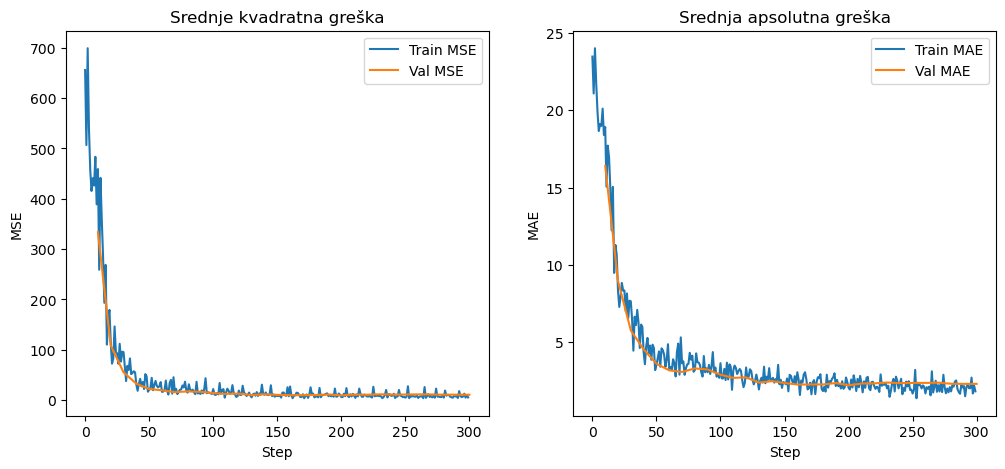

In [20]:
# vizualizacija metrika
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['train_step'], metrics['train_mse'], label='Train MSE')
plt.plot(metrics['val_step'], metrics['val_mse'], label='Val MSE')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.title('Srednje kvadratna greška')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics['train_step'], metrics['train_mae'], label='Train MAE')
plt.plot(metrics['val_step'], metrics['val_mae'], label='Val MAE')
plt.xlabel('Step')
plt.ylabel('MAE')
plt.title('Srednja apsolutna greška')
plt.legend()

plt.show()

In [21]:
model.eval()
test_mse, test_mae, test_samples = 0, 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        batch_size = inputs.size(0)


        predictions = model(inputs).squeeze()
        mse = (predictions - labels).pow(2).mean()
        mae = (predictions - labels).abs().mean()

        test_mse += mse.item() * batch_size
        test_mae += mae.item() * batch_size
        test_samples += batch_size
test_mse /= test_samples
test_mae /= test_samples
print(f"{test_mae=}")
print(f"{test_mse=}")

test_mae=2.2496162224672513
test_mse=12.478582467861518


## Čuvanje modela

Kao što smo napomenuli, za svaki sloj mreže postoji matrica parametara i matrica slobodnih članova. Sve parametre modela, kao i njegove slobodne članove možemo dobit pozivom funckije `model.state_dict()`.

In [22]:
print(model.state_dict().keys())
print(type(model.state_dict()))


odict_keys(['model.0.weight', 'model.0.bias', 'model.2.weight', 'model.2.bias'])
<class 'collections.OrderedDict'>


In [23]:
for weight_name in model.state_dict():
    print(weight_name, model.state_dict()[weight_name].shape)

model.0.weight torch.Size([100, 13])
model.0.bias torch.Size([100])
model.2.weight torch.Size([1, 100])
model.2.bias torch.Size([1])


Pozivom funkcije `torch.save` možemo čuvati vrednosti parametara modela, kao i cele modele. Fajlove koje kreiramo pozivom `torch.save` funkcije se po konvenciji koriste `.pth` ekstenziju.

In [24]:
torch.save(model.state_dict(), 'saved_models/model.pth')

In [25]:
torch.save(model, 'saved_models/model_full.pth')

Fajl napravljen `torch.save` funkcijom možemo pročitati funkcijom `torch.load`.

In [28]:
model_revived = torch.load('saved_models/model_full.pth')

/tmp/ipykernel_51312/3642480482.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_revived = torch.load('saved_models/model_full.pth')


In [29]:
model.load_state_dict(torch.load('saved_models/model.pth', weights_only=True))

<All keys matched successfully>

Učitani model se može koristiti na način na koji smo to do sada i radili.

Zajednica koja se bavi mašinskim učenjem ulaže napore da standardizuje formate za čuvanje mreža. Jedan od njih je i [ONNX](https://onnx.ai/) za koji torch biblioteka nudi [podršku](https://pytorch.org/docs/stable/onnx.html). O ovim temam će svakako biti više reči i u nastavku kursa.
<img src='assets/onnx.png'>

In [30]:
torch.onnx.export(model, torch.randn(1, number_of_features, device=DEVICE),f="model.onnx")

Ukoliko nam je potreban uvid u samu arhitekturu mreže, možemo generisati i grafički prikaz korišćenjem biblioteke torchviz. Za ova generisanja nam je potrebna i bibliteka `graphviz`.

In [31]:
from torchviz import make_dot

dummy_input = torch.randn(1, number_of_features).to(DEVICE)
output = model(dummy_input)
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_pytorch", format="png")

'model_pytorch.png'

Vizuelizacije mreže će biti moguće i kroz alat [TensorBoard](https://www.tensorflow.org/tensorboard) koji ćemo, takođe, upoznati na nekom od narednih časova.